In [28]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler


# Load and Preprocess Data
def load_and_preprocess(directory, label=None):
    data_frames = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            if label is not None:
                df["Label"] = label  # Assign class labels
            data_frames.append(df)
    df = pd.concat(data_frames, ignore_index=True)
    
    # Encode categorical data
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    # Handle missing values
    df.fillna(df.median(), inplace=True)
    
    return df

# Load Data
dataset_path_healthy = "/home/admincit/Desktop/Team_4/split_fif/healthy_csv"
dataset_path_mdd = "/home/admincit/Desktop/Team_4/split_fif/mdd_csv"

df_healthy = load_and_preprocess(dataset_path_healthy, label=0)  # 0 for Healthy
df_mdd = load_and_preprocess(dataset_path_mdd, label=1)  # 1 for MDD

df = pd.concat([df_healthy, df_mdd], axis=0).reset_index(drop=True)

# Split Features and Labels
X = df.drop(columns=['Label']).values
y = df['Label'].values

# Standardize Data
scaler = MinMaxScaler(feature_range=(0,100)) # Min-Max scaling preserves relative magnitudes meaning the differences between EEG signal strengths are still maintained, unlike standardization, which centers data around 0.
X_scaled = scaler.fit_transform(X)


# Split into Train, Validation & Test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp)

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

joblib.dump(scaler, "best_xgb_scaler.pkl")

# Define XGBoost Model
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    device="cuda",
    eval_metric="logloss",
    learning_rate=0.005,
    max_depth=25,
    gamma=0.2,
    subsample=0.95,
    colsample_bytree=0.97,
    min_child_weight=1,
    reg_alpha=0.8,
    reg_lambda=3.0,
    n_estimators=6000,
    verbosity=1
)

# Perform Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=cv, scoring="accuracy")

# Train Model
xgb_model.fit(X_train, y_train)
joblib.dump(xgb_model, "best_xgb_model.pkl")

# Evaluate on Validation Set
val_preds = xgb_model.predict(X_val)
val_probs = xgb_model.predict_proba(X_val)[:, 1]
accuracy = accuracy_score(y_val, val_preds)
roc_auc = roc_auc_score(y_val, val_probs)
report = classification_report(y_val, val_preds)
# print(f"Accuracy: {accuracy:.4f}")

# Print Results

print(f"Validation Accuracy: {accuracy:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", report)
print(f"cross valscores : {cv_scores}")


/mnt/data/saikrishna/Team_4/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:07:16] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.9643
ROC AUC Score: 0.9948

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.94      1.00      0.97        16

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

cross valscores : [0.63636364 0.90909091 0.78125    0.78125    0.875     ]


In [2]:
from sklearn.calibration import CalibratedClassifierCV
calibrated_xgb = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=5)
calibrated_xgb.fit(X_train, y_train)
val_probs = calibrated_xgb.predict_proba(X_val)[:, 1]

In [3]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_val, val_preds))
print(f"ROC AUC: {roc_auc_score(y_val, val_probs):.4f}")


              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.94      1.00      0.97        16

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.96        28
weighted avg       0.97      0.96      0.96        28

ROC AUC: 0.9896


In [4]:
report = classification_report(y_val, val_preds)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_val, val_preds)

from sklearn.metrics import balanced_accuracy_score
bal_acc = balanced_accuracy_score(y_val, val_preds)
print(f"Balanced Accuracy: {bal_acc:.4f}")

from sklearn.metrics import log_loss
logloss = log_loss(y_val, val_preds)
print(f"Log Loss: {logloss:.4f}")

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_val, val_preds)
print(f"Cohen's Kappa: {kappa:.4f}")


Balanced Accuracy: 0.9583
Log Loss: 1.2873
Cohen's Kappa: 0.9263


In [30]:
feature_names = df.drop(columns=['Label']).columns.tolist()

In [31]:
feature_names

['ec_fp1_mean',
 'ec_fp1_variance',
 'ec_fp1_skewness',
 'ec_fp1_kurtosis',
 'ec_fp1_peak_to_peak',
 'ec_fp1_fft_mean',
 'ec_fp1_fft_std',
 'ec_fp1_fft_max',
 'ec_fp1_wavelet_energy',
 'ec_fp1_wavelet_entropy',
 'ec_fp2_mean',
 'ec_fp2_variance',
 'ec_fp2_skewness',
 'ec_fp2_kurtosis',
 'ec_fp2_peak_to_peak',
 'ec_fp2_fft_mean',
 'ec_fp2_fft_std',
 'ec_fp2_fft_max',
 'ec_fp2_wavelet_energy',
 'ec_fp2_wavelet_entropy',
 'ec_f7_mean',
 'ec_f7_variance',
 'ec_f7_skewness',
 'ec_f7_kurtosis',
 'ec_f7_peak_to_peak',
 'ec_f7_fft_mean',
 'ec_f7_fft_std',
 'ec_f7_fft_max',
 'ec_f7_wavelet_energy',
 'ec_f7_wavelet_entropy',
 'ec_f3_mean',
 'ec_f3_variance',
 'ec_f3_skewness',
 'ec_f3_kurtosis',
 'ec_f3_peak_to_peak',
 'ec_f3_fft_mean',
 'ec_f3_fft_std',
 'ec_f3_fft_max',
 'ec_f3_wavelet_energy',
 'ec_f3_wavelet_entropy',
 'ec_fz_mean',
 'ec_fz_variance',
 'ec_fz_skewness',
 'ec_fz_kurtosis',
 'ec_fz_peak_to_peak',
 'ec_fz_fft_mean',
 'ec_fz_fft_std',
 'ec_fz_fft_max',
 'ec_fz_wavelet_energy',
 

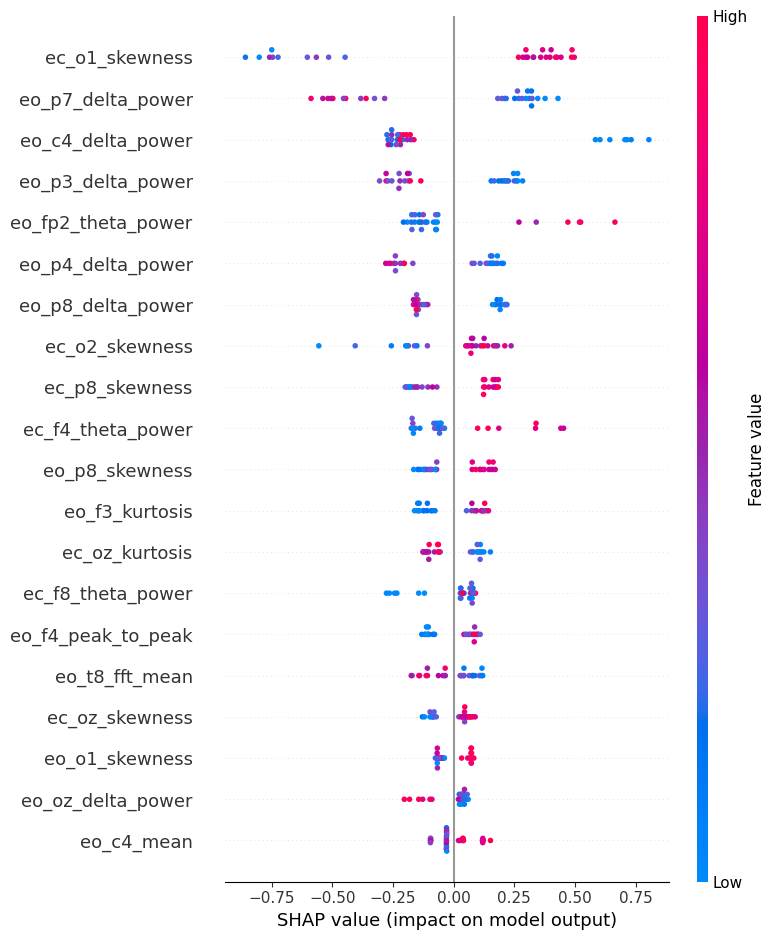

ValueError: Could not find feature named: fp_1_mean

In [29]:
import shap

# Load the trained model and scaler (optional if already in memory)
xgb_model = joblib.load("best_xgb_model.pkl")
scaler = joblib.load("best_xgb_scaler.pkl")

# Convert X_val back to DataFrame with original feature names
feature_names = df.drop(columns=["Label"]).columns  # Extract feature names
X_val_df = pd.DataFrame(X_val, columns=feature_names)

# ✅ Initialize SHAP Explainer
explainer = shap.Explainer(xgb_model, X_val_df)

# ✅ Compute SHAP values
shap_values = explainer(X_val_df)

# ✅ Summary Plot (Overall Feature Importance)
shap.summary_plot(shap_values, X_val_df)

# ✅ Force Plot (Single Prediction Explanation)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0].values, X_val_df.iloc[0])

# ✅ Dependence Plot for a Specific Feature (Change "fp_1_mean" to any feature name)
shap.dependence_plot("fp_1_mean", shap_values, X_val_df)

# ✅ SHAP Bar Plot (Top Features)
shap.bar_plot(shap_values)


In [28]:
# Initialize SHAP Explainer
X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_val_df = pd.DataFrame(X_val, columns=feature_names)

explainer = shap.Explainer(xgb_model, X_train_df)

# Compute SHAP values for validation set
shap_values = explainer(X_val_df)


ValueError: Shape of passed values is (162, 834), indices imply (162, 835)

# All models

In [2]:
pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 9.9 MB/s eta 0:00:00ta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load and Preprocess Data
def load_and_preprocess(directory, label=None):
    data_frames = []
    for file in os.listdir(directory):
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, file))
            if label is not None:
                df["Label"] = label  # Assign class labels
            data_frames.append(df)
    df = pd.concat(data_frames, ignore_index=True)
    
    # Encode categorical data
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = LabelEncoder().fit_transform(df[col])
    
    # Handle missing values
    df.fillna(df.median(), inplace=True)
    
    return df


# Load Data
dataset_path_healthy = "/home/admincit/Desktop/Team_4/split_fif/healthy_csv"
dataset_path_mdd = "/home/admincit/Desktop/Team_4/split_fif/mdd_processed"

df_healthy = load_and_preprocess(dataset_path_healthy, label=0)  # 0 for Healthy
df_mdd = load_and_preprocess(dataset_path_mdd, label=1)  # 1 for MDD

df = pd.concat([df_healthy, df_mdd], axis=0).reset_index(drop=True)

# Split Features and Labels
X = df.drop(columns=['Label']).values
y = df['Label'].values

# Scale Data
scaler = MinMaxScaler(feature_range=(0, 100))
X_scaled = scaler.fit_transform(X)

# Save the scaler
# joblib.dump(scaler, "binary_scaler.pkl")

# Split into Train, Validation & Test
random_states = [42, 100, 200]  # Different random states for robustness

models = {
    "XGBoost": xgb.XGBClassifier(
        objective="binary:logistic",
        tree_method="hist",
        device="cuda",
        eval_metric="logloss",
        learning_rate=0.005,
        max_depth=25,
        gamma=0.2,
        subsample=0.95,
        colsample_bytree=0.97,
        min_child_weight=1,
        reg_alpha=0.8,
        reg_lambda=3.0,
        n_estimators=6000,
        verbosity=1
    ),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "Logistic Regression": LogisticRegression(solver='liblinear', C=1.0, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, C=1.0, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "LightGBM": lgb.LGBMClassifier(num_leaves=31, learning_rate=0.01, n_estimators=500)
}

# Loop through each random state
for state in random_states:
    print(f"\n----- Results for Random State {state} -----")
    
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=state, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=state, stratify=y_temp)

    # Apply the same scaling transformation to val & test sets
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        print(f"\nTraining model: {name}")

        # Perform Cross-Validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=state)
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")

        if name == "XGBoost":
            # Convert to DMatrix for GPU Acceleration
            dtrain = xgb.DMatrix(X_train, label=y_train, nthread=-1)
            dval = xgb.DMatrix(X_val_scaled, label=y_val, nthread=-1)

            # Train using GPU
            model.fit(X_train, y_train)

            # Save the trained model
            # joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

            # Predict using GPU
            val_preds = model.predict(X_val_scaled)
            val_probs = model.predict_proba(X_val_scaled)[:, 1]

        else:
            # Train CPU-based models
            model.fit(X_train, y_train)

            # Save the trained model
            # joblib.dump(model, f"{name.replace(' ', '_')}_model.pkl")

            # Predict normally
            val_preds = model.predict(X_val_scaled)
            val_probs = model.predict_proba(X_val_scaled)[:, 1] if hasattr(model, "predict_proba") else None

        accuracy = accuracy_score(y_val, val_preds)
        roc_auc = roc_auc_score(y_val, val_probs) if val_probs is not None else "N/A"
        report = classification_report(y_val, val_preds)

        # Print Results
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(f"ROC AUC Score: {roc_auc}")
        print("Classification Report:\n", report)
        print(f"Cross-Validation Scores: {cv_scores}")



----- Results for Random State 42 -----

Training model: XGBoost


/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.4074074074074074
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.77142857 0.77142857 0.97058824 0.76470588 0.85294118]

Training model: Random Forest


/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.2708333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.71428571 0.68571429 0.88235294 0.79411765 0.88235294]

Training model: Logistic Regression
Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.82857143 0.77142857 0.79411765 0.82352941 

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.71428571 0.6        0.67647059 0.73529412 0.76470588]

Training model: Decision Tree
Validation Accuracy: 0.5667
ROC AUC Score: 0.4722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.59      0.94      0.72        18

    accuracy                           0.57        30
   macro avg       0.29      0.47      0.36        30
weighted avg       0.35      0.57      0.43        30

Cross-Validation Scores: [0.71428571 0.77142857 0.76470588 0.64705882 0.7352

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 84, number of negative: 54
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39198
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608696 -> initscore=0.441833
[LightGBM] [Info] Start training from score 0.441833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 84, number of negative: 54
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39198
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608696 -> initscore=0.441833
[LightGBM] [Info] Start training from score 0.441833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Validation Accuracy: 0.6000
ROC AUC Score: 0.6273148148148148
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.85714286 0.82857143 0.88235294 0.73529412 0.85294118]

Training model: Random Forest


/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.5648148148148149
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.88571429 0.85714286 0.85294118 0.88235294 0.88235294]

Training model: Logistic Regression
Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.85714286 0.8        0.82352941 0.76470588 

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.71428571 0.71428571 0.64705882 0.70588235 0.73529412]

Training model: Decision Tree
Validation Accuracy: 0.5667
ROC AUC Score: 0.4861111111111111
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.08      0.13        12
           1       0.59      0.89      0.71        18

    accuracy                           0.57        30
   macro avg       0.46      0.49      0.42        30
weighted avg       0.49      0.57      0.48        30

Cross-Validation Scores: [0.65714286 0.6        0.64705882 0.67647059 0.7058

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 84, number of negative: 54
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003644 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39198
[LightGBM] [Info] Number of data points in the train set: 138, number of used features: 834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608696 -> initscore=0.441833
[LightGBM] [Info] Start training from score 0.441833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Validation Accuracy: 0.6000
ROC AUC Score: 0.5393518518518519
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.8        0.91428571 0.85294118 0.76470588 0.85294118]

Training model: Random Forest


/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.4722222222222222
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.74285714 0.77142857 0.91176471 0.88235294 0.76470588]

Training model: Logistic Regression
Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.71428571 0.85714286 0.88235294 0.82352941 

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.71428571 0.74285714 0.85294118 0.76470588 0.70588235]

Training model: KNN
Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.54285714 0.62857143 0.82352941 0.52941176 0.85294118]

Training model: De

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

Validation Accuracy: 0.6000
ROC AUC Score: 0.5
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.60      1.00      0.75        18

    accuracy                           0.60        30
   macro avg       0.30      0.50      0.38        30
weighted avg       0.36      0.60      0.45        30

Cross-Validation Scores: [0.62857143 0.82857143 0.73529412 0.79411765 0.61764706]

Training model: LightGBM
[LightGBM] [Info] Number of positive: 84, number of negative: 53
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39198
[LightGBM] [Info] Number of data points in the train set: 137, number of used features: 834
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613139 -> initscore=0.460525
[LightGBM] [Info] Start training from score 0.460525
[LightGB

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/admincit/Desktop/Team_4/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis